___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-2 (CNN)<br><br>Image Classification with CNN<br><h1>

# Task and Dataset Info

Welcome to second assignment of Deep learning lesson. Follow the instructions and complete the assignment.

**Build an image classifier with Convolutional Neural Networks for the Fashion MNIST dataset. This data set includes 10 labels of different clothing types with 28 by 28 *grayscale* images. There is a training set of 60,000 images and 10,000 test images.**

    Label	Description
    0	    T-shirt/top
    1	    Trouser
    2	    Pullover
    3	    Dress
    4	    Coat
    5	    Sandal
    6	    Shirt
    7	    Sneaker
    8	    Bag
    9	    Ankle boot

# Import Libraries

In [1]:
import os
import random
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)
pd.set_option("display.max_columns", None)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam
from tensorflow.keras.utils import to_categorical
import optuna
import pickle

c:\Users\white\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if tf.config.list_physical_devices("GPU"):
    print("GPU support is enabled for this session.")
else:
    print("CPU will be used for this session.")

GPU support is enabled for this session.


In [3]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)

tf.config.experimental.enable_op_determinism()

# Recognizing and Understanding Data

**TASK 1: Run the code below to download the dataset using Keras.**

In [4]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [5]:
print(f"There are {len(X_train)} images in the training dataset")
print(f"There are {len(X_test)} images in the test dataset")

There are 60000 images in the training dataset
There are 10000 images in the test dataset


In [6]:
X_train[1].shape

(28, 28)

In [7]:
# Validatation data split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=SEED, stratify=y_train)

In [8]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((51000, 28, 28), (9000, 28, 28), (51000,), (9000,))

**TASK 2: Use matplotlib to view an image from the data set. It can be any image from the data set.**

In [9]:
# Labels
classes=["T-shirt/top", "Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

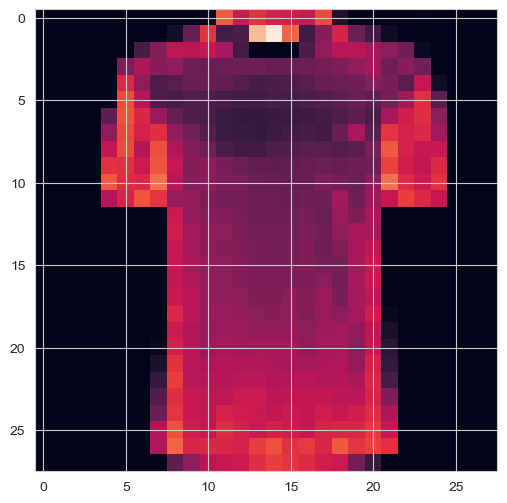

In [10]:
plt.imshow(X_train[10])

<Axes: >

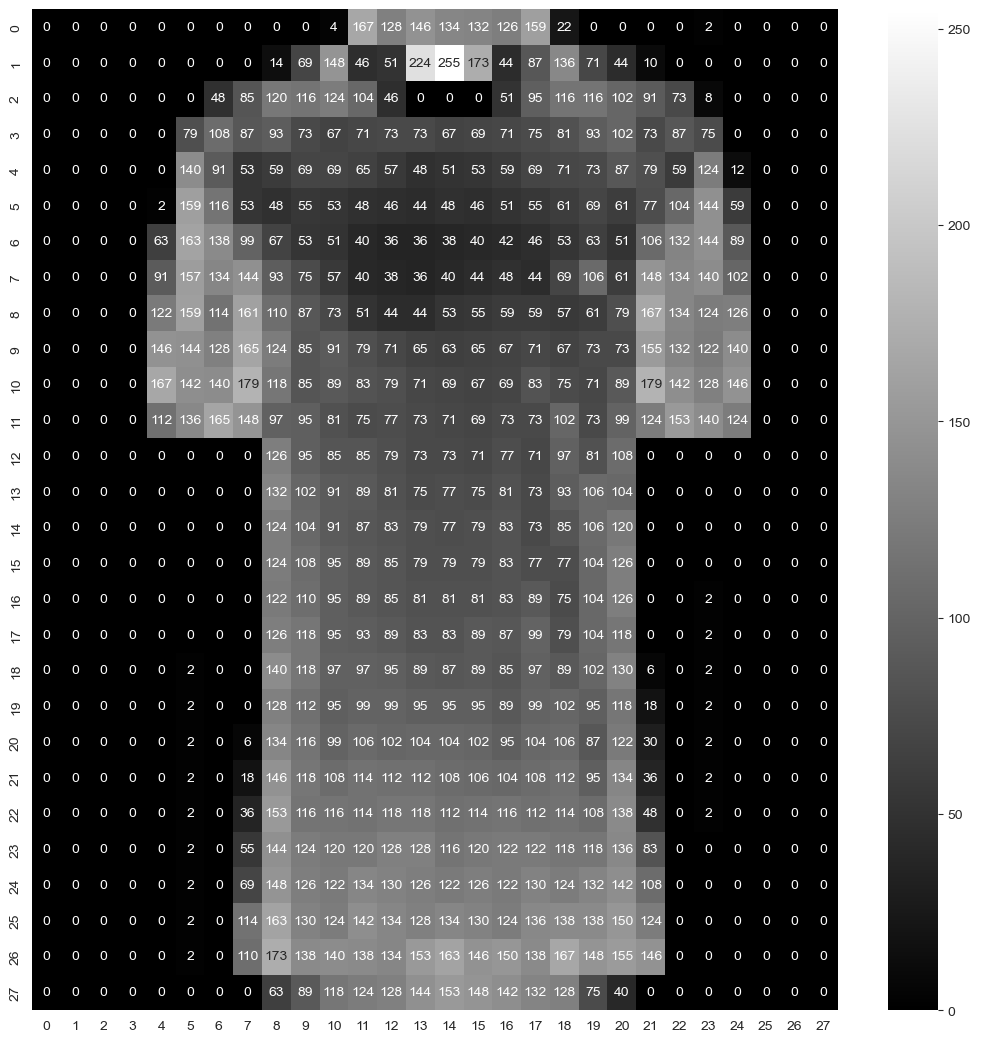

In [11]:
plt.figure(figsize=(13, 13))
sns.heatmap(X_train[10], annot=True, cmap="gray", fmt=".3g")

# Data Preprocessing

**TASK 3: Normalize the X train and X test data by dividing by the max value of the image arrays.**

In [12]:
# Check max value to normalize the data
X_train[100].max()

255

In [13]:
# Normalization
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_val = X_val.astype("float32")
X_train /= 255
X_test /= 255
X_val /= 255

In [14]:
# New values range [0, 1]
X_train[100].max()

1.0

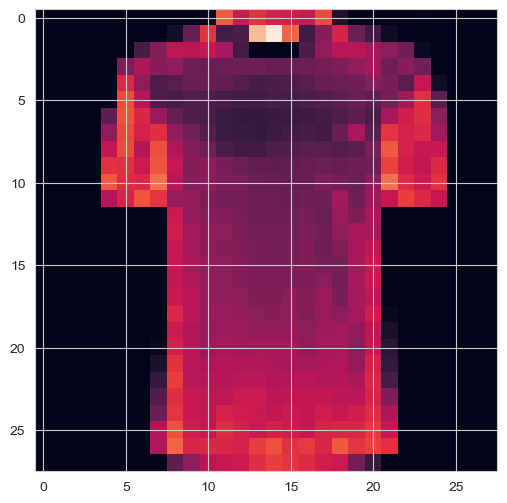

In [15]:
# No change after normalization
plt.imshow(X_train[10])

**Task 4: Reshape the X arrays to include a 4 dimension of the single channel. Similar to what we did for the numbers MNIST data set.**

In [16]:
# Adding a dimension to indicate greyscale
X_train = np.expand_dims(X_train, 3)
X_test = np.expand_dims(X_test, 3)
X_val = np.expand_dims(X_val, 3)

In [17]:
X_train.shape, X_test.shape, X_val.shape

((51000, 28, 28, 1), (10000, 28, 28, 1), (9000, 28, 28, 1))

**TASK 5: Convert the y_train and y_test values to be one-hot encoded for categorical analysis by Keras.**

In [18]:
# One-hot encoding the labels for categorical analyses
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)
Y_val = to_categorical(y_val, 10)

In [19]:
Y_train.shape

(51000, 10)

In [20]:
Y_train[10]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Modeling

## Create the model

**TASK 5: Use Keras to create a model consisting of at least the following layers (but feel free to experiment):**

* 2D Convolutional Layer, filters=28 and kernel_size=(3,3)
* Pooling Layer where pool_size = (2,2) strides=(1,1)

* Flatten Layer
* Dense Layer (128 Neurons, but feel free to play around with this value), RELU activation

* Final Dense Layer of 10 Neurons with a softmax activation

**Then compile the model with these parameters: loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']**

In [21]:
model = Sequential([Conv2D(filters=28, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1), activation="relu"),
                    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation="relu"),
                    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"),
                    MaxPool2D(pool_size=(2, 2)),
                    Flatten(),
                    Dense(128, activation="relu"),
                    Dense(10, activation="softmax")])

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        280       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        16192     
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                        

##  Model Training 

**TASK 6: Train/Fit the model to the x_train set by using EarlyStop. Amount of epochs is up to you.**

In [23]:
# Early stopping on val_loss 
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights=True
)

In [24]:
model.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_val, Y_val), callbacks=[early_stop])

Epoch 1/100
797/797 [==============================] - 10s 10ms/step - loss: 0.3679 - accuracy: 0.8673 - val_loss: 0.2405 - val_accuracy: 0.9133
Epoch 2/100
797/797 [==============================] - 8s 10ms/step - loss: 0.2071 - accuracy: 0.9254 - val_loss: 0.2084 - val_accuracy: 0.9247
Epoch 3/100
797/797 [==============================] - 7s 9ms/step - loss: 0.1567 - accuracy: 0.9440 - val_loss: 0.2019 - val_accuracy: 0.9311
Epoch 4/100
797/797 [==============================] - 7s 9ms/step - loss: 0.1185 - accuracy: 0.9581 - val_loss: 0.2357 - val_accuracy: 0.9326
Epoch 5/100
797/797 [==============================] - 7s 9ms/step - loss: 0.0901 - accuracy: 0.9677 - val_loss: 0.2661 - val_accuracy: 0.9162
Epoch 6/100
797/797 [==============================] - 8s 10ms/step - loss: 0.0686 - accuracy: 0.9755 - val_loss: 0.3288 - val_accuracy: 0.9313
Epoch 7/100
797/797 [==============================] - 8s 10ms/step - loss: 0.0531 - accuracy: 0.9813 - val_loss: 0.3320 - val_accuracy: 0

**TASK 7: Plot values of metrics you used in your model.**

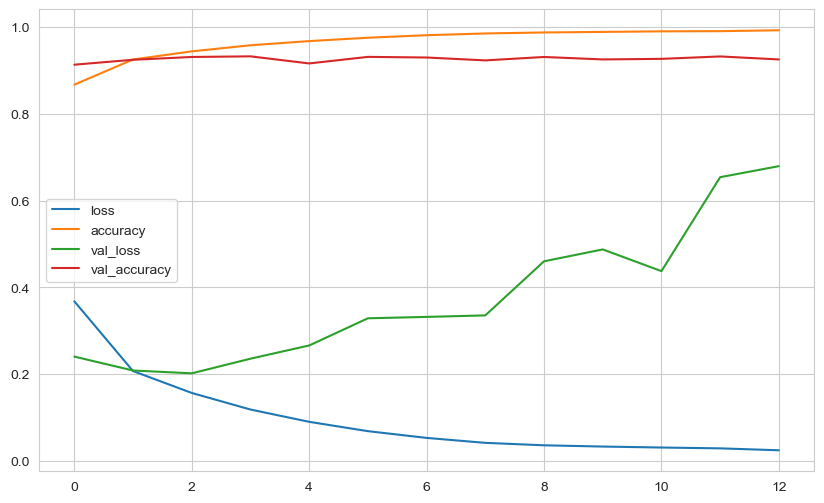

In [25]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()
plt.show()

## Model Evaluation

**TASK 8: Show the accuracy,precision,recall,f1-score the model achieved on the x_test data set. Keep in mind, there are quite a few ways to do this, but we recommend following the same procedure we showed in the MNIST lecture.**

In [26]:
model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2254 - accuracy: 0.9197


[0.2254183292388916, 0.919700026512146]

In [27]:
pred_prob = model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [28]:
# get the target with the highest probability
y_pred = np.argmax(pred_prob, axis=1)

In [29]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[836   0  18  14   4   1 119   0   8   0]
 [  1 976   0  12   4   0   3   0   4   0]
 [ 11   0 838   7  76   0  66   0   2   0]
 [ 10   2  13 907  41   0  27   0   0   0]
 [  1   0  17  14 937   0  31   0   0   0]
 [  0   0   0   0   0 987   0  10   0   3]
 [ 71   0  33  22  67   0 797   0  10   0]
 [  0   0   0   0   0   7   0 988   0   5]
 [  1   0   0   1   5   2   0   1 990   0]
 [  0   0   0   0   0   6   1  52   0 941]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1000
           1       1.00      0.98      0.99      1000
           2       0.91      0.84      0.87      1000
           3       0.93      0.91      0.92      1000
           4       0.83      0.94      0.88      1000
           5       0.98      0.99      0.99      1000
           6       0.76      0.80      0.78      1000
           7       0.94      0.99      0.96      1000
           8       0.98      0.99      0.98      1000
           9       0.99     

## Prediction

In [36]:
image = X_test[10]

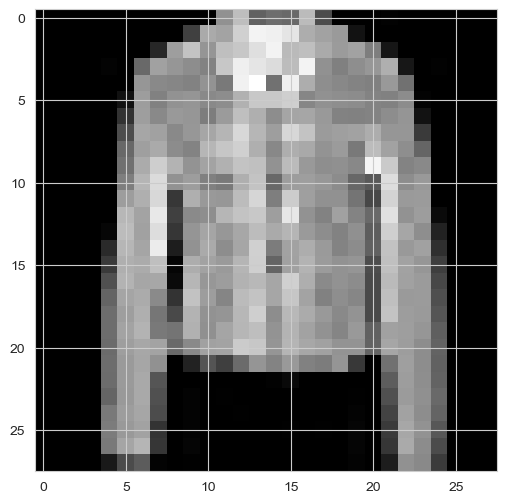

In [37]:
plt.imshow(image, cmap="gray")

In [38]:
np.expand_dims(image, 0).shape

(1, 28, 28, 1)

In [39]:
pred_prob = model.predict(np.expand_dims(image, 0))

1/1 [==============================] - 0s 17ms/step


In [40]:
y_pred = np.argmax(pred_prob)
y_pred

4

In [41]:
# Check the class name
classes[y_pred]

'Coat'

# End of Assignment

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___